#Import

In [3]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Build Network

In [4]:
M = 128
class Net_Wave(nn.Module):
    def __init__(self):
        super(Net_Wave, self).__init__()
        torch.manual_seed(333)
        self.hidden_layer1 = nn.Linear(2,M)
        torch.manual_seed(333)
        self.hidden_layer2 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer3 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer4 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.output_layer = nn.Linear(M,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)

        return output

#set PDE,residual

In [5]:
N=10

In [6]:
def f(x, t, net):
    u = net(x,t)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]

    pde = u_tt - u_xx

    return pde

#Define Additional Partial Derivative

In [7]:
def dt(x,t, net):
    u = net(x,t)

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    return u_t

def dx(x,t, net):
    u = net(x,t)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

    return u_x

#Set Observer Point

In [8]:
ob_x=np.arange(0,1,0.01)
ob_t=np.arange(0,1,0.01)

ms_x, ms_t= np.meshgrid(ob_x,ob_t)

ob_x = np.ravel(ms_x).reshape(-1,1)
ob_t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(ob_x).float(), requires_grad=False).to(device)
pt_t = Variable(torch.from_numpy(ob_t).float(), requires_grad=False).to(device)

#loss,optimizer

In [9]:
mse_cost_function = torch.nn.MSELoss()

net_wave = Net_Wave()
net_wave = net_wave.to(device)
optimizer = torch.optim.Adam(net_wave.parameters())

#Set Condition data

In [15]:
##---------------------------------Condition Domain--------------------------------##

x_Dt0 = np.random.uniform(low = 0 , high = N , size=(128,1))
x_DDt0 = np.random.uniform(low = 0 , high = N , size=(128,1))
t_Dx0 = np.random.uniform(low = 0 , high = N , size=(128,1))
t_DxN = np.random.uniform(low = 0 , high = N , size=(128,1))
x_0 = np.zeros((128,1))
t_0 = np.zeros((128,1))
x_N = np.ones((128,1))*N

##---------------------------------Condition Label--------------------------------##

u_t0 = np.zeros((128,1))
u_Dt0 = 2/N*np.pi*np.sin(2/N*np.pi*x_DDt0) + 10/N*np.pi*np.sin(10/N*np.pi*x_DDt0)
u_x0 =  np.zeros((128,1))
u_xN =  np.zeros((128,1))

##--------------------------------make tensor-----------------------------------##

C_x_Dt0 = Variable(torch.from_numpy(x_Dt0).float(), requires_grad=True).to(device)
C_t_Dx0 = Variable(torch.from_numpy(t_Dx0).float(), requires_grad=True).to(device)
C_x_DDt0 = Variable(torch.from_numpy(x_DDt0).float(), requires_grad=True).to(device)
C_t_DxN = Variable(torch.from_numpy(t_DxN).float(), requires_grad=True).to(device)
C_x_0 = Variable(torch.from_numpy(x_0).float(), requires_grad=True).to(device)
C_t_0 = Variable(torch.from_numpy(t_0).float(), requires_grad=True).to(device)
C_x_N = Variable(torch.from_numpy(x_N).float(), requires_grad=True).to(device)

##--------------------------------label tensor-----------------------------------##

pt_u_t0 = Variable(torch.from_numpy(u_t0).float(), requires_grad=False).to(device)
pt_u_Dt0 = Variable(torch.from_numpy(u_Dt0).float(), requires_grad=False).to(device)
pt_u_x0 = Variable(torch.from_numpy(u_x0).float(), requires_grad=False).to(device)
pt_u_xN = Variable(torch.from_numpy(u_xN).float(), requires_grad=False).to(device)

##--------------------------------Residual Label---------------------------------##
all_zeros = np.zeros((6400,1))
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

#Train

In [57]:
iterations = 60205
previous_validation_loss = 99999999.0

for epoch in range(iterations):

    optimizer.zero_grad()

##-------------------------------Condition predict output------------------------------------##

    net_x0_out = net_wave(C_x_0, C_t_Dx0)
    net_xN_out = net_wave(C_x_N, C_t_DxN)
    net_xIC_out = net_wave(C_x_Dt0, C_t_0)
    net_DxIC_out = dt(C_x_DDt0, C_t_0, net_wave)

##------------------------------------Condition Loss-----------------------------------------##
    mse_x0t = mse_cost_function(net_x0_out, pt_u_x0)
    mse_xNt = mse_cost_function(net_xN_out, pt_u_xN)
    mse_xt0 = mse_cost_function(net_xIC_out, pt_u_t0)
    mse_Dxt0 = mse_cost_function(net_DxIC_out, pt_u_Dt0)

# ##------------------------------------Set Interior Domain-----------------------------------------##
    x_collocation = np.random.uniform(low=0, high=N, size=(6400,1))
    t_collocation = np.random.uniform(low=0, high=N, size=(6400,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)

##------------------------------------Compute Loss-----------------------------------------##
    f_out = f(pt_x_collocation, pt_t_collocation, net_wave)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    loss = mse_x0t + mse_xNt + mse_xt0 + mse_Dxt0 + mse_f

##------------------------------------Optimize-----------------------------------------##
    loss.backward()
    optimizer.step()

##----------------------------Relative L2 Error-----------------------------##
    if (epoch) % 100 == 0:
        Solution = torch.sin(2*torch.pi*pt_t)*torch.sin(2*torch.pi*pt_x)+torch.sin(10*torch.pi*pt_t)*torch.sin(10*torch.pi*pt_x)
        pt_u = net_wave(N*pt_x,N*pt_t)

        gap3 = torch.sqrt(((Solution - pt_u)**2).mean()/(Solution**2).mean())
        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)
        print(gap3)

-----------------------------------------------------------------------------
Epoch: 0
tensor(0.2117, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 100
tensor(0.2105, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 200
tensor(0.2056, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 300
tensor(0.2087, device='cuda:0', grad_fn=<SqrtBackward0>)


KeyboardInterrupt: 

#Plot Prediction

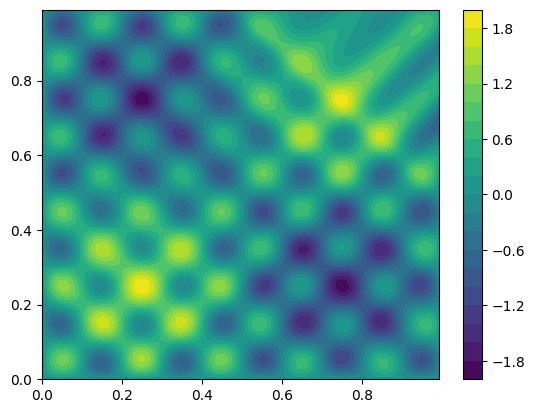

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
# plt.figure(figsize=(4,8))
# ax = fig.add_subplot(projection = '3d')

x=np.arange(0,1,0.01)
t=np.arange(0,1,0.01)

ms_x, ms_t= np.meshgrid(x,t)

x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)

pt_u = net_wave(N*pt_x,N*pt_t)


u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)



plt.contourf(ms_t, ms_x , ms_u, levels=20)
plt.colorbar() 

plt.show()